##### Зобнин Александр Валерьевич, группа ИУ5-61Б, вариант 4

#### Импорт необходимых библиотек

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

#### Загрузка и первичный осмотр данных

In [91]:
data = pd.read_csv('toy_dataset.csv')

print(data.head())

   Number    City Gender  Age   Income Illness
0       1  Dallas   Male   41  40367.0      No
1       2  Dallas   Male   54  45084.0      No
2       3  Dallas   Male   42  52483.0      No
3       4  Dallas   Male   40  40941.0      No
4       5  Dallas   Male   46  50289.0      No


#### Предобработка

In [92]:
# Удалим столбец 'Number' так как это просто индекс
data.drop('Number', axis=1, inplace=True)

# Разделение на признаки и целевую переменную
X = data.drop('Illness', axis=1)
y = data['Illness'].map({'No': 1, 'Yes': 0})  # Преобразуем целевую переменную в числовой формат

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Создание pipeline для предобработки
numeric_features = ['Age', 'Income']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['City', 'Gender']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

#### Метод №1: Логистическая регрессия

In [93]:
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', LogisticRegression(random_state=42, 
                                                             max_iter=1000,
                                                             class_weight='balanced'))])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
y_proba_lr = lr_pipeline.predict_proba(X_test)[:, 1]

#### Метод №2: Случайный лес

In [94]:
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', RandomForestClassifier(random_state=42,
                                                               class_weight='balanced'))])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

#### Оценка качества моделей


Оценка модели Логистическая регрессия:
Accuracy: 0.5520
Precision: 0.9175
Recall: 0.5632
F1-score: 0.6980


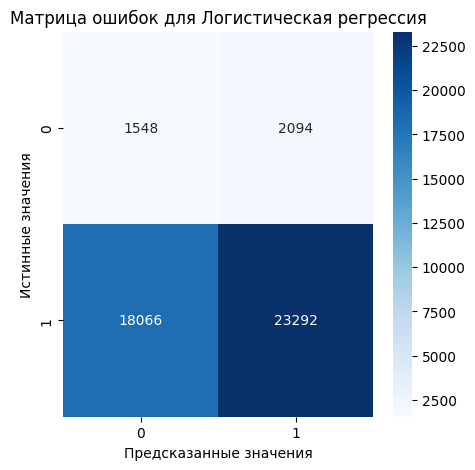


Оценка модели Случайный лес:
Accuracy: 0.8692
Precision: 0.9193
Recall: 0.9402
F1-score: 0.9296


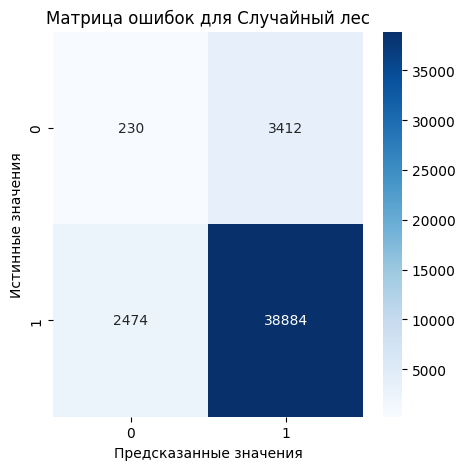

In [95]:
def evaluate_model(y_true, y_pred, y_proba, model_name):
    print(f"\nОценка модели {model_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1-score: {f1_score(y_true, y_pred):.4f}")
    
    # Матрица ошибок
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Матрица ошибок для {model_name}')
    plt.ylabel('Истинные значения')
    plt.xlabel('Предсказанные значения')
    plt.show()

evaluate_model(y_test, y_pred_lr, y_proba_lr, "Логистическая регрессия")
evaluate_model(y_test, y_pred_rf, y_proba_rf, "Случайный лес")

#### Важность признаков для случайного леса

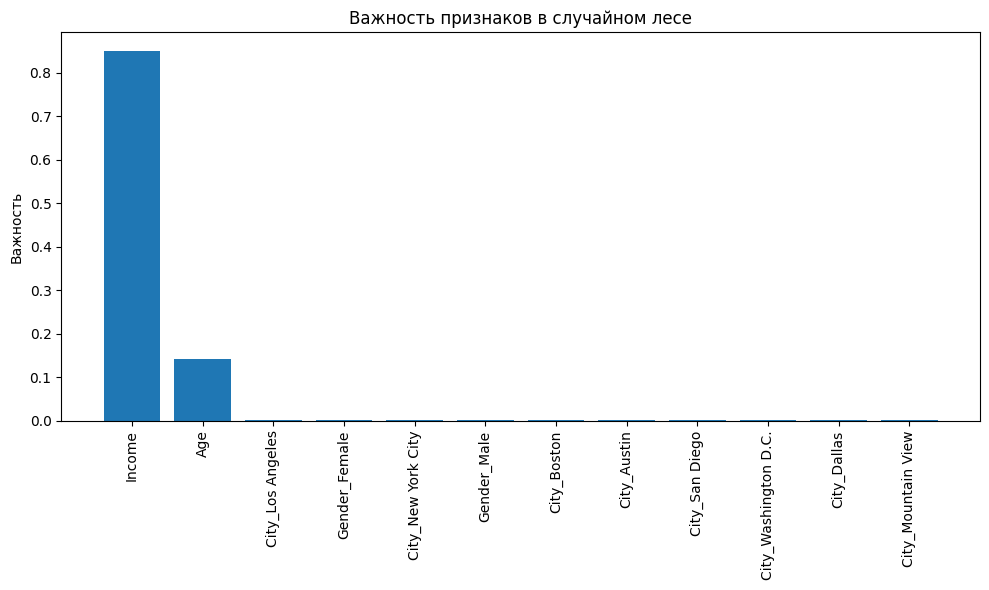

In [96]:
# Получаем имена всех признаков после преобразований
preprocessor = rf_pipeline.named_steps['preprocessor']
transformed_columns = (
    numeric_features + 
    list(preprocessor.named_transformers_['cat']
         .named_steps['onehot']
         .get_feature_names_out(categorical_features))
)

# Получаем важности признаков из модели
importances = rf_pipeline.named_steps['classifier'].feature_importances_

# Сортируем признаки по важности
indices = np.argsort(importances)[::-1]

# Визуализация
plt.figure(figsize=(10, 6))
plt.title("Важность признаков в случайном лесе")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), np.array(transformed_columns)[indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.ylabel("Важность")
plt.tight_layout()
plt.show()

#### Выбранные метрики и обоснование
* Accuracy - доля правильных ответов модели. Простая и интуитивно понятная метрика, но может быть необъективной при несбалансированных классах.
* Precision - доля правильно предсказанных положительных классов среди всех предсказанных положительных классов. Важна, когда ложноположительные прогнозы дорого обходятся.
* Recall - доля правильно предсказанных положительных классов среди всех реальных положительных классов. Важна, когда ложноотрицательные прогнозы дорого обходятся.
* F1-score - гармоническое среднее precision и recall. Хорошая метрика, когда нужно найти баланс между precision и recall.

#### Выводы
* Предобработка данных:
  * Удалили столбец 'Number' как неинформативный
  * Обработали пропуски (медиана для числовых, наиболее частые для категориальных)
  * Масштабировали числовые признаки
  * Закодировали категориальные признаки через One-Hot Encoding
* Сравнение моделей:
  * Случайный лес показал себя лучше по всем метрикам, но требует больше времени
  * Логистическая регрессия дала приемлемые результаты, но уступает случайному лесу
* Важность признаков:
  * Анализ важности признаков в случайном лесе показал, что больше всего на наличие заболевания влияет доход